<a href="https://colab.research.google.com/github/alheliou/ModelInversion/blob/main/data_leakage_from_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.tensorflow.org/tutorials/keras/text_classification
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns

import os
import re
import shutil
import string

from scipy import special
import scipy.stats as ss

from sklearn.linear_model import LogisticRegression
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Conv2D, Activation, Dropout, Flatten, Input, Dense, Softmax, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import losses

# Helper Functions for Text and Images

In [2]:
def calculate_all_l2_distances(reconstructed_samples, original_samples):
  """

  """
  num_orig_samples = original_samples.shape[0]
  features = original_samples.shape[1]

  l2_dists = np.zeros((len(reconstructed_samples), len(original_samples))) # how many reconstructed and how many original 
  for i in range(len(original_samples)):

    l2_dist = np.linalg.norm((reconstructed_samples-original_samples[i].reshape(1, features)), axis=1)
    l2_dists[:, i] = l2_dist

  # replace the nan values
  l2_dists = np.nan_to_num(l2_dists, nan=3072)
  return l2_dists 

def get_per_data_point_closest_sample_indices(distances_array):
  """Distances array should be in shape num_reconstructed samples, num_original samples
  Each cell gives the l2 dist between the reconstructed and the original sample"""
  closest_samples_indices = np.argmin(distances_array, axis=0)

  return closest_samples_indices

def calculate_l2distance_of_closest_sample(closest_samples, original_samples):
  """Given the closest (according to l2_norm, or VGG embedding) samples and the corresponding original samples, return an array of their l2 distances"""

  distances = np.linalg.norm(closest_samples-original_samples, axis=1)

  return distances

def calculate_attack_recall(distances, l2_dist_eps):
  """Looks for every training example, how many reconstructed samples lie in the l2_dist_eps ball around it.
  Returns per sample numbers of close reconstructions, and the percentage of images that got reconstructions"""


  # find all the entries that are smaller than the l2_dist_eps somewhere in the array
  smaller_mask = distances<l2_dist_eps

  per_example_sum = np.sum(smaller_mask, axis=0)

  # for what percentage of samples did we get a reconstruction
  percentage = np.sum(per_example_sum!=0)/per_example_sum.shape[0]

  return per_example_sum, percentage

def calculate_attack_precision(distances, l2_dist_eps):
  """Of all the reconstructed samples, what percentage is in the l2_dist_eps ball around any training sample?
  Measures hardness of reconstruction. """

  # find all the entries that are smaller than the l2_dist_eps somewhere in the array
  smaller_mask = distances<l2_dist_eps

  # now look row-wise if there is any 
  per_element_true = np.any(smaller_mask, axis=1)

  percentage = np.sum(per_element_true) / per_element_true.shape[0]

  return percentage

In [3]:
# we should scale down the positive weights
def generate_symmetric_points(num_elements, down_scale_factor=0.95, mu=0.0, sigma=0.5):
    """num_pos says roughly how many positive elements we want to have"""

    vector = np.random.normal(mu, sigma, num_elements)

    # make all negative (such that we can better control)
    abs_vector = abs(vector) * (-1)

    num_pos = np.floor(num_elements / 2).astype(int)

    # random positive indices
    pos_indices = np.random.choice(num_elements, num_pos, replace=False)

    negative_elements = np.delete(abs_vector, pos_indices)

    abs_vector[pos_indices] = -down_scale_factor * negative_elements  # set the negative values and turn them positive

    return abs_vector

def weight_initializer(weights_shape, initializer_function, **kwargs):
    """
    Will generate the weights in weight_shape, by filling each row with the given initializer function
    :param weights_shape: shape of the final weights (shape[0] are usually our data features, shape[1] are the number of
    neurons in the next layer
    :param initializer_function: a function that fills every every row in the weight matrix
    :return: initialized weights
    """
    # weight shape will be input-features (our data), output features

    row_length = weights_shape[0]
    number_rows = weights_shape[1]

    weights = np.zeros((row_length, number_rows))
    for i in range(number_rows):
        weights[:, i] = initializer_function(row_length, **kwargs)

    return weights


In [4]:
def process_gradients(gradients, bias):
  """Given the gradients perform the following operations:
  1. Calculate Inverse Bias
  2. Multiply Gradients with Inverse Bias to Rescale Them
  3. Remove NaN Values
  4. Transpose, such that number of examples is first axis"""

  inverse_bias = 1/bias
  rescaled_c = gradients * inverse_bias



  rescaled_c_no_nan = rescaled_c[:, ~np.isnan(rescaled_c).any(axis=0)]

  rescaled_c_no_nan = rescaled_c_no_nan.T #transpose such that first axis is number of samples

  return rescaled_c_no_nan

# Text

## Text Data Loading

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 61s 1us/step


In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 200
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-06-16 21:32:13.197614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Being the only movie I was able to see at this year\'s "Nordische Filmtage" at L\xc3\xbcbeck, this year\'s festival will be remembered as a all-time low for me.<br /><br />This movie, which was announced as an erotic thriller, is nothing more than a sick piece of crap! Excuse the language, but there aren\'t any decent words to describe it.<br /><br />First of all, the actors are not the best. But even better actors would not have rescued the movie. E.g. the plot: after the first 15 minutes it was quite clear that John was sick, the neighbour girls were not real and that he killed his first girlfriend. The so called "sex-scene" was nothing else but disgusting (hitting each other until blood flows for me hasn\'t anything to do with sexuality), but unfortunately that were not the only disgusting images to be shown. Everything else was copied by other directors like e.g. Lynch, but of course without their geniality.<br /><br />So, to summarize the whole film and to save other view

In [11]:
# validation and test set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Text Data Preprocessing

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000 # have lower vocab size to avoid big probalems with the float rounding
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I went into this film thinking it would be a crappy b-rated movie. I came out surprised and very amused. Eva was good, but Lake Bell stole the show. She had amazing comedic timing. The jokes in this film were surprisingly original and really funny with one or two flat jokes in between. The plot was enough to tie it all together, a woman (Eva) dies on her wedding day and comes back to haunt the woman that is going out with her was-to-be husband, its sounds far-fetched but it actually works quite well. <br /><br />7/10 - Overall its a worthwhile cinema watch, if not get it on DVD when it comes out.', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,   81,   11,   19,  520,    9,   59,   26,    4, 2080,
           1,   17,   10,  371,   44,  747,    3,   52, 5081, 3411,   13,
          49,   18, 2157, 3747, 3876,    2,  119,   55,   66,  463, 1696,
        2868,    2,  617,    8,   11,   19,   65, 11

In [17]:
# print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 313 --->  night
Vocabulary size: 10000


In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
# get the train data
data_batch = []
label_batch = []
for element in train_ds.as_numpy_iterator():
  data_batch.append(element[0])
  label_batch.append(element[1])
  print(element)
  break

train_data_use = np.asarray(data_batch).squeeze()#[0].reshape(1, 250)
train_labels_use = np.asarray(label_batch).reshape(batch_size,1)


(array([[6737, 1102,    1, ...,    0,    0,    0],
       [   1,    1,  290, ...,    0,    0,    0],
       [  10,   66,    2, ...,    0,    0,    0],
       ...,
       [ 600,    8,    2, ...,    0,    0,    0],
       [  11,   13,   28, ...,    0,    0,    0],
       [   2,   86, 1958, ...,   14, 1860,   59]]), array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1], dtype=int32))


## Text Data Inversion: From Embedding to Text and the Other Way Round

Use a separate Embedding Layer. Thereby, we "outsource" the computation of the embedding from the model from which we want to extract.

Then, learn the backward pass (which embedding comes from which token).

We can then invert the embedding that we extracted back from the fully connected layer.

In [20]:
from collections import defaultdict

# make embedding layer
embedding_dim = 250
emb_layer = layers.Embedding(max_features + 1, embedding_dim, embeddings_initializer= tf.keras.initializers.RandomUniform(minval=0.0, maxval=1., seed=None))#tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.1))

# learn the inversion
inv = defaultdict(lambda: -1)

inv[0.0] = 0.0


red = lambda x: str(f"{int(np.sum(x)*(10**5))}") # in order to avoid problems with the floating point accuracy, we round. #hash over sums to be replaced ...
# this might make us lose some individual mappings (but below we see that it is only very few.)

for t in range(max_features):
  emb = emb_layer(np.array([t]))
  inv[red(emb)] = t

emb_train_data_use = emb_layer(train_data_use)
print(len(inv.keys()), max_features)


9963 10000


## Random Initialization Experiments

In [21]:
def process_gradients_according_to_bias(gradients, bias):
    """
  Rescales gradients of the first layer according to the bias.
  Given the gradients perform the following operations:
  1. Calculate Inverse Bias
  2. Multiply Gradients with Inverse Bias to Rescale Them
  3. Remove NaN Values
  4. Transpose, such that number of examples is first axis
  :param gradients: numpy array of gradients of model weights (usually at first layer)
  :param bias: numpy array of gradients of model bias (at same layer as gradients)
  :return: the rescaled gradients without NaN gradients (that might result when the corresponding neuron does not fire)
  """

    inverse_bias = 1 / bias
    rescaled_grad = gradients * inverse_bias

    rescaled_grad_no_nan = rescaled_grad[:, ~np.isnan(rescaled_grad).any(axis=0)]

    rescaled_grad_no_nan = rescaled_grad_no_nan.T  # transpose such that first axis is number of samples

    return rescaled_grad_no_nan


In [22]:
L2_DIST = 0.01 # Find Data Samples in this close distance
NUM_NEURONS = 1000
BATCH_SIZES = 20 # How many data samples in the batch
FEATURES = 250*sequence_length

In [23]:


# create model
model = Sequential()
model.add(Dense(NUM_NEURONS, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build((None,FEATURES))  


loss=losses.BinaryCrossentropy(from_logits=True)
x = emb_train_data_use.numpy().reshape([emb_train_data_use.shape[0], -1])[:BATCH_SIZES].reshape(BATCH_SIZES,-1)
#x = scale_layer(emb_train_data_use).numpy().reshape([emb_train_data_use.shape[0], -1])[:SAMPLES_USE].reshape(SAMPLES_USE,-1)
y =  train_labels_use[:BATCH_SIZES].reshape(BATCH_SIZES,-1)
with tf.GradientTape() as tape:
  # Forward pass.
  logits = model(x)
  # Loss value for this batch.
  loss_value = loss(y, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)

grad = gradients[0].numpy()
bias = gradients[1].numpy()

rescaled_gradients = process_gradients_according_to_bias(grad, bias)


/Users/aliceheliou/Documents/Thales/ModelInversion/python_env/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/Users/aliceheliou/Documents/Thales/ModelInversion/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/aliceheliou/Documents/Thales/ModelInversion/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [24]:
num_nan = NUM_NEURONS - rescaled_gradients.shape[0]


distances = calculate_all_l2_distances(rescaled_gradients, x)
closest_samples_indices = get_per_data_point_closest_sample_indices(distances)
closest_samples = rescaled_gradients[closest_samples_indices]
l2_dists = calculate_l2distance_of_closest_sample(closest_samples, x)
_, attack_recall = calculate_attack_recall(distances, L2_DIST)
attack_precision = calculate_attack_precision(distances, L2_DIST)

In [25]:
attack_recall # how many of the embeddings for sentences could be extracted perfectly?

0.9

## Adversarial Initialization Experiments



In [26]:
model = Sequential()
model.add(Dense(NUM_NEURONS, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build((None,FEATURES))  

# set the model weights according to the initializer
initializer = generate_symmetric_points
hyperparameter = {'down_scale_factor': 0.99}
weights_shape = (FEATURES, NUM_NEURONS)
weights = weight_initializer(weights_shape, initializer, **hyperparameter) #todo pass the kwargs
bs = np.zeros(NUM_NEURONS)
model.layers[0].set_weights([weights, bs])

loss=losses.BinaryCrossentropy(from_logits=True)
x = emb_train_data_use.numpy().reshape([emb_train_data_use.shape[0], -1])[:BATCH_SIZES].reshape(BATCH_SIZES,-1)
#x = scale_layer(emb_train_data_use).numpy().reshape([emb_train_data_use.shape[0], -1])[:SAMPLES_USE].reshape(SAMPLES_USE,-1)
y =  train_labels_use[:BATCH_SIZES].reshape(BATCH_SIZES,-1)
with tf.GradientTape() as tape:
  # Forward pass.
  logits = model(x)
  # Loss value for this batch.
  loss_value = loss(y, logits)

# Get gradients of loss wrt the weights.
gradients = tape.gradient(loss_value, model.trainable_weights)

grad = gradients[0].numpy()
bias = gradients[1].numpy()

rescaled_gradients = process_gradients_according_to_bias(grad, bias)
        

/Users/aliceheliou/Documents/Thales/ModelInversion/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/aliceheliou/Documents/Thales/ModelInversion/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [27]:
num_nan = NUM_NEURONS - rescaled_gradients.shape[0]
distances = calculate_all_l2_distances(rescaled_gradients, x)

closest_samples_indices = get_per_data_point_closest_sample_indices(distances)
closest_samples = rescaled_gradients[closest_samples_indices]
l2_dists = calculate_l2distance_of_closest_sample(closest_samples, x)

_, attack_recall = calculate_attack_recall(distances, L2_DIST)
attack_precision = calculate_attack_precision(distances, L2_DIST)

In [28]:
attack_recall

1.0

In [29]:
# Print the inverted sentence. ??? means that the inversion dict was not precise enough
# We are working with floating points. Therefore, translation back over the hash values might not always 
# be perfect.

# However, looking two cells above, we see the recall is 1, ie. extracting the embeddings works perfectly
# we are able to perfectly have the embeddings and just need a better hash function for inversion 
# back to text
_dit = vectorize_layer.get_vocabulary()


resh_resc = closest_samples[0].reshape((-1, sequence_length))
sentence = []
for i in range(sequence_length):

  tok = inv[red(resh_resc[i])]
  if tok < 0:    
    sentence.append(f"???")
  else:
    sentence.append(_dit[tok])

" ".join(sentence)

# inv[red(resh_resc[i])]

'gus van [UNK] has made some excellent films i truly ??? a fan however i cant help but feel that the cerebral edge of tom robbins book even [UNK] get the blues is lost in ??? to the big ??? alone tom robbins and gus van [UNK] are incredible [UNK] and towers of ??? ultimately though this one just didnt work it ??? that the characters werent well developed or the plot and content didnt come ??? its just that our [UNK] are much more powerful when ??? a book like this were taken away to a different time and place and we sometimes think the worst ??? the best and it adds to the ??? rollercoaster of the book as it ??? ??? according to the authors precision movies however can ??? one with less of the imagination and emotion rollercoaster [UNK] from the ??? experience this is what i believe ??? here i suggest ??? the book                                                                                           '

In [30]:
# this cell prints us the original sentence
" ".join([_dit[token] for token in train_data_use[0].astype(int)])

'gus van [UNK] has made some excellent films i truly am a fan however i cant help but feel that the cerebral edge of tom robbins book even [UNK] get the blues is lost in translation to the big screen alone tom robbins and gus van [UNK] are incredible [UNK] and towers of talent ultimately though this one just didnt work it wasnt that the characters werent well developed or the plot and content didnt come alive its just that our [UNK] are much more powerful when reading a book like this were taken away to a different time and place and we sometimes think the worst andor the best and it adds to the overall rollercoaster of the book as it neatly unfolds according to the authors precision movies however can leave one with less of the imagination and emotion rollercoaster [UNK] from the overall experience this is what i believe happened here i suggest reading the book                                                                                           '

# Image

Use CIFAR10 as an example

## Image Data Loading

In [31]:
def load_cifar_10():
    """Loads CIFAR10-Dataset and preprocesses it."""
    train, test = tf.keras.datasets.cifar10.load_data()

    train_data, train_labels = train
    test_data, test_labels = test

    # form of normalization used until 10.11.2020
    # mean = np.mean(train_data, axis=(0, 1, 2, 3))
    # std = np.std(train_data, axis=(0, 1, 2, 3))
    # train_data = (train_data - mean) / (std + 1e-7)
    # test_data = (test_data - mean) / (std + 1e-7)
    train_labels = train_labels.flatten()  # added for skript 51 # TODO:check if still works for training cifar
    test_labels = test_labels.flatten()
    train_data, test_data = train_data / 255.0, test_data / 255.0

    return train_data, train_labels, test_data, test_labels

In [32]:
train_data, train_labels, test_data, test_labels = load_cifar_10()
train_data_flat = train_data.reshape(50000,32*32*3)
FEATURES = 32*32*3
shape = (32,32,3)

170498071/170498071 [==============================] - 80s 0us/step


In [66]:
# make the model
model = Sequential()
model.add(Dense(NUM_NEURONS, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.5)))
model.add(Dense(10))
model.build((None,FEATURES))

In [67]:
train_data_use = train_data_flat[:BATCH_SIZES].reshape(BATCH_SIZES,FEATURES) # [0, 2] because these are the samples that differ now
y = train_labels[:BATCH_SIZES]
train_data_use.shape, y.shape
train_data_use_2 = train_data_flat[BATCH_SIZES:2*BATCH_SIZES].reshape(BATCH_SIZES,FEATURES) # [0, 2] because these are the samples that differ now
y_2 = train_labels[BATCH_SIZES:2*BATCH_SIZES]

## Random Initialization Experiments

In [68]:
x = train_data_use
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
with tf.GradientTape() as tape:
  # Forward pass.
  logits = model(x)
  # Loss value for this batch.
  loss_value = loss(y, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)

In [69]:
gradient = gradients[0].numpy()
bias = gradients[1].numpy()
inverse_bias = 1/bias
rescaled_gradients = gradient * inverse_bias
# remove the NaNs (for more compact representation in figure)
rescaled_gradients = rescaled_gradients[:, ~np.isnan(rescaled_gradients).any(axis=0)].T

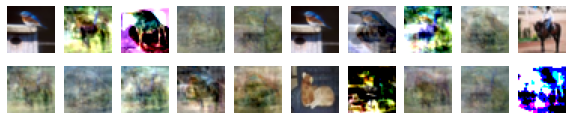

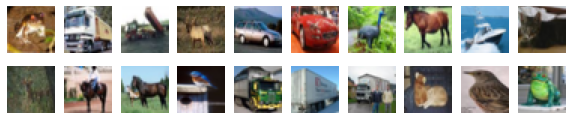

In [71]:
num_row = 2
num_col = 10
num_samples = num_row*num_col


# Reconstructed
fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(rescaled_gradients[i].reshape(shape))   

# Learning data
fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(x[i].reshape(shape))  

In [72]:
x_2 = train_data_use_2
with tf.GradientTape() as tape:
  # Forward pass.
  logits = model(x_2)
  # Loss value for this batch.
  loss_value = loss(y_2, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)

gradient = gradients[0].numpy()
bias = gradients[1].numpy()
inverse_bias = 1/bias
rescaled_gradients = gradient * inverse_bias
# remove the NaNs (for more compact representation in figure)
rescaled_gradients = rescaled_gradients[:, ~np.isnan(rescaled_gradients).any(axis=0)].T

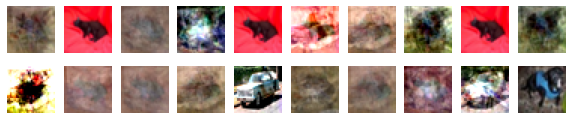

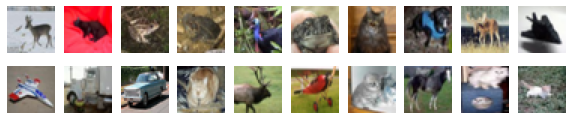

In [73]:
num_row = 2
num_col = 10
num_samples = num_row*num_col


# Reconstructed
fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(rescaled_gradients[i].reshape(shape))   

# Learning data
fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(x_2[i].reshape(shape))  

In [79]:
# Loop over the data
l2_distances = []
recall = []
precision = []
global_recall = []
global_precision = []
print(len(train_data_flat)//BATCH_SIZES, "batches to consider")
# make the model
model = Sequential()
model.add(Dense(NUM_NEURONS, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.5)))
model.add(Dense(10))
model.build((None,FEATURES))
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
for i in range(len(train_data_flat)//BATCH_SIZES):
    # Get batch
    train_data_use = train_data_flat[i*BATCH_SIZES:(i+1)*BATCH_SIZES].reshape(BATCH_SIZES,FEATURES) # [0, 2] because these are the samples that differ now
    y = train_labels[i*BATCH_SIZES:(i+1)*BATCH_SIZES]
    x = train_data_use
    # Train on batch
    with tf.GradientTape() as tape:
        # Forward pass.
        logits = model(x)
        # Loss value for this batch.
        loss_value = loss(y, logits)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
    gradient = gradients[0].numpy()
    bias = gradients[1].numpy()
    inverse_bias = 1/bias
    rescaled_gradients = gradient * inverse_bias
    # remove the NaNs (for more compact representation in figure)
    rescaled_gradients = rescaled_gradients[:, ~np.isnan(rescaled_gradients).any(axis=0)].T
    # Calculate and Display Success Metrics
    rescaled_gradients = process_gradients(gradient, bias)

    distances = calculate_all_l2_distances(rescaled_gradients, train_data_use)
    closest_samples_indices = get_per_data_point_closest_sample_indices(distances)
    closest_samples = rescaled_gradients[closest_samples_indices]
    l2_dists = calculate_l2distance_of_closest_sample(closest_samples, train_data_use)
    _, attack_recall = calculate_attack_recall(distances, L2_DIST) # looks like anything upto 6 really resembles the image - 10 makes a lot of false positives. So probably anywhere between?
    attack_precision = calculate_attack_precision(distances, L2_DIST)

    global_distances = calculate_all_l2_distances(rescaled_gradients, train_data_flat)
    global_closest_samples_indices = get_per_data_point_closest_sample_indices(global_distances)
    global_closest_samples = rescaled_gradients[global_closest_samples_indices]
    global_l2_dists = calculate_l2distance_of_closest_sample(global_closest_samples, train_data_flat)
    _, global_attack_recall = calculate_attack_recall(global_distances, L2_DIST) # looks like anything upto 6 really resembles the image - 10 makes a lot of false positives. So probably anywhere between?
    global_attack_precision = calculate_attack_precision(global_distances, L2_DIST)


    l2_distances.append((np.min(l2_dists), np.max(l2_dists)))
    recall.append(attack_recall)
    precision.append(attack_precision)
    global_recall.append(global_attack_recall)
    global_precision.append(global_attack_precision)
    print("attack metric on batch",i, attack_recall, attack_precision)
    print("attack metric on all the train data", global_attack_recall, global_attack_precision)

print(l2_distances)
print(recall)
print(precision)


2500 batches to consider
attack metric on batch 0 0.9 0.09950859950859951
attack metric on all the train data 0.00036 0.09950859950859951


KeyboardInterrupt: 

In [74]:
# Calculate and Display Success Metrics
rescaled_gradients = process_gradients(gradient, bias)
print("shape: ", rescaled_gradients.shape)

distances = calculate_all_l2_distances(rescaled_gradients, train_data_use_2)

closest_samples_indices = get_per_data_point_closest_sample_indices(distances)
closest_samples = rescaled_gradients[closest_samples_indices]
l2_dists = calculate_l2distance_of_closest_sample(closest_samples, train_data_use_2)
_, attack_recall = calculate_attack_recall(distances, L2_DIST) # looks like anything upto 6 really resembles the image - 10 makes a lot of false positives. So probably anywhere between?
attack_precision = calculate_attack_precision(distances, L2_DIST)

print("l2 distances ", np.min(l2_dists), np.max(l2_dists))
print("Recall: ", attack_recall)
print("Precision: ", attack_precision)

shape:  (814, 3072)
l2 distances  5.534438240432805e-07 6.150964910677498
Recall:  0.85
Precision:  0.0945945945945946


## Adversarial Initialization

In [59]:
# make the model
model = Sequential()
model.add(Dense(NUM_NEURONS, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.5)))
model.add(Dense(10))
model.build((None,FEATURES))

initializer = generate_symmetric_points
hyperparameter = {'down_scale_factor': 0.95}
weights_shape = (FEATURES, NUM_NEURONS)
weights = weight_initializer(weights_shape, initializer, **hyperparameter) #todo pass the kwargs
bs = np.zeros(NUM_NEURONS)
model.layers[0].set_weights([weights, bs])

In [60]:
with tf.GradientTape() as tape:
  # Forward pass.
  logits = model(x)
  # Loss value for this batch.
  loss_value = loss(y, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)

In [61]:
gradient = gradients[0].numpy()
bias = gradients[1].numpy()
inverse_bias = 1/bias
rescaled_gradients = gradient * inverse_bias
# remove the NaNs (for more compact representation in figure)
rescaled_gradients = rescaled_gradients[:, ~np.isnan(rescaled_gradients).any(axis=0)].T

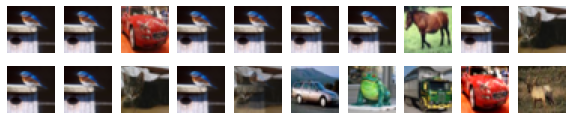

In [62]:
num_row = 2
num_col = 10
num_samples = num_row*num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(rescaled_gradients[i].reshape(shape))   

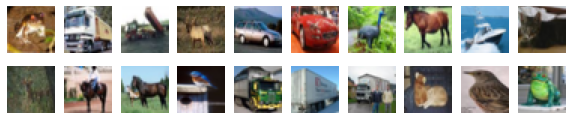

In [64]:
# Set of input
num_row = 2
num_col = 10
num_samples = num_row*num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(x[i].reshape(shape)) 

In [63]:
# Calculate and Display Success Metrics
rescaled_gradients = process_gradients(gradient, bias)
print("shape: ", rescaled_gradients.shape)

distances = calculate_all_l2_distances(rescaled_gradients, train_data_use)

closest_samples_indices = get_per_data_point_closest_sample_indices(distances)
closest_samples = rescaled_gradients[closest_samples_indices]
l2_dists = calculate_l2distance_of_closest_sample(closest_samples, train_data_use)
_, attack_recall = calculate_attack_recall(distances, L2_DIST) # looks like anything upto 6 really resembles the image - 10 makes a lot of false positives. So probably anywhere between?
attack_precision = calculate_attack_precision(distances, L2_DIST)

print("l2 distances ", np.min(l2_dists), np.max(l2_dists))
print("Recall: ", attack_recall)
print("Precision: ", attack_precision)

shape:  (339, 3072)
l2 distances  5.139382485424068e-07 7.93421130820176
Recall:  0.95
Precision:  0.7905604719764012


## One-Liner To Show Success

In [43]:
# suppress the warnings "divide by zero" that are produced by the NaN gradients
import warnings
warnings.filterwarnings("ignore")

# suppress matplotlib warning that image values must be between 0 and 255
# (when samples overlay in our gradients, they will be larger potentially)
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [44]:
def plot_gradients(gradients, num_rows=2, num_cols=10):
  num_rows = 2
  num_cols = 10

  # filter out the gradients with a NaN for more compact figure 
  # Otherwise, there will be black samples 
  gradients = gradients[:, ~np.isnan(gradients).any(axis=0)]

  fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_cols,1.*num_rows))
  for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(gradients[:,i].reshape(shape), vmin=0., vmax=1.)   

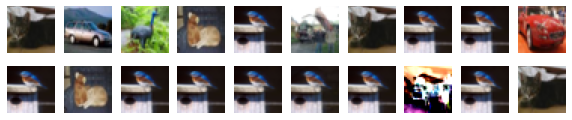

In [45]:
first_layer_weights_gradient = gradients[0].numpy()
first_layer_inverse_bias = 1/gradients[1].numpy()
extracted_data = first_layer_weights_gradient * first_layer_inverse_bias
plot_gradients(extracted_data, num_rows=2, num_cols=10)

## Additional Plots: Original Samples that could be restored

In [46]:
def plot_samples_that_have_partner(closest_samples, l2_dists, rows, cols, img_shape):

  num_samples = len(closest_samples)



  num_row = rows
  num_col = cols


  fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
  for i, ax in enumerate(axes.flat):


      #ax = axes[i//num_col, i%num_col]
      ax.set_axis_off()
      
      
      empty_sample = np.zeros(img_shape)
      

      # no partner
      if l2_dists[i] > 1:
        ax.imshow(empty_sample.reshape(img_shape))
      else: 

        ax.imshow(closest_samples[i].reshape(img_shape))
      
  plt.suptitle("Restored Samples")
  return fig

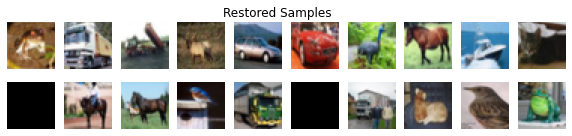

In [47]:
figure = plot_samples_that_have_partner(closest_samples, l2_dists, 2, 10, shape)

In [48]:
def plot_original_samples(samples, rows, cols, img_shape, title="Restored Samples", cmap=None):
    """Given the closest samples and their distances, plot them accroding to the train samples"""

    num_row = rows
    num_col = cols

    fig, axes = plt.subplots(num_row, num_col, figsize=(1. * num_col, 1. * num_row))
    for i, ax in enumerate(axes.flat):

        ax.set_axis_off()
        ax.imshow(samples[i].reshape(img_shape), cmap=cmap)

    #plt.suptitle(title)

    return fig

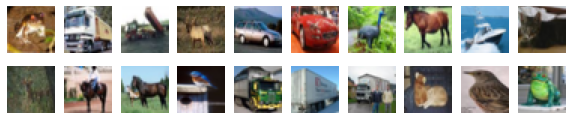

In [49]:
figure = plot_original_samples(train_data_use, 2, 10, shape)

